About the dataset

**Mechanic Component Images ( Normal / Defected)**


**About Dataset**
This dataset is of casting manufacturing product.
Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.
Reason for collect this data is casting defects!!
Casting defect is an undesired irregularity in a metal casting process.
There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.
Defects are an unwanted thing in casting industry. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human accuracy, this is not 100% accurate. This can because of the rejection of the whole order. So it creates a big loss in the company.

We decided to make the inspection process automatic and for this, we need to make deep learning classification model for this problem.

link:/kaggle/input/real-life-industrial-dataset-of-casting-product

In [1]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
random.seed(555)

#Visualizing the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path= "/content/drive/MyDrive/casting_data"


In [4]:
dir_train = '/content/drive/MyDrive/casting_data/casting_data/train/'
dir_test = '/content/drive/MyDrive/casting_data/casting_data/test/'

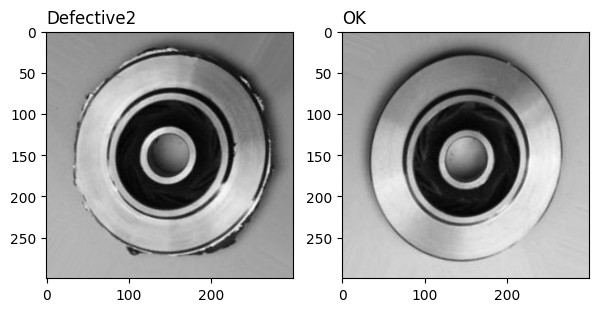

In [5]:
data_defected2= dir_train+'def_front/'
data_normal=dir_train+'ok_front/'

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(7,4))
sample_def2 = plt.imread(data_defected2+os.listdir(data_defected2)[0])
sample_ok = plt.imread(data_normal+os.listdir(data_normal)[0])

axes[0].imshow(sample_def2)
axes[1].imshow(sample_ok)

axes[0].set_title('Defective2', loc='left')
axes[1].set_title('OK', loc='left')

axes[0].grid(False)
axes[1].grid(False)

plt.show()

<Axes: >

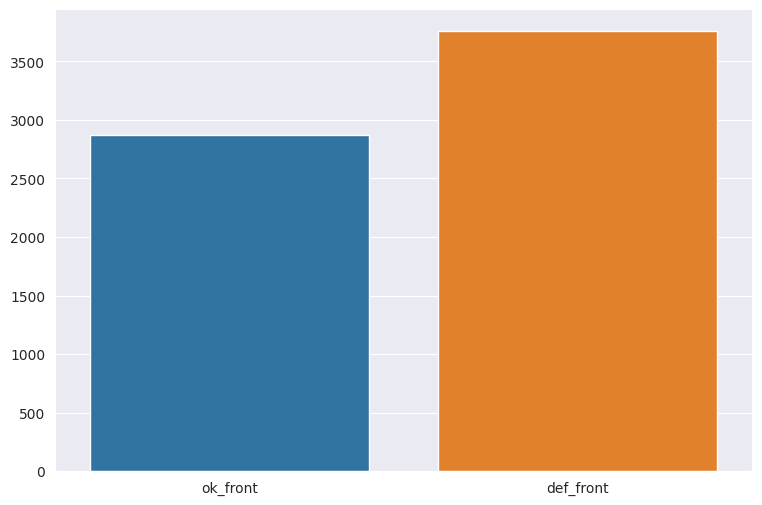

In [6]:
import seaborn as sns
data_set = []  # List to store folder names
amount_of_each = []  # List to store the number of items in each folder

# Loop through each folder in the specified directory
for folder in os.listdir(dir_train):
    data_set.append(folder)  # Add folder name to data_set list
    amount_of_each.append(len(os.listdir(os.path.join(dir_train, folder))))  # Add the number of items in the folder to amount_of_each list

# Create a bar plot using seaborn and matplotlib
plt.figure(figsize=(9, 6))  # Set the size of the figure
sns.set_style('darkgrid')  # Set the style of the seaborn plot to darkgrid
sns.barplot(x=data_set, y=amount_of_each)  # Create a bar plot with folder names on the x-axis and the number of items on the y-axis


#Data Augementation

In [7]:
# We can observe that we can generate more examples just using rotations
img_size = (300,300)
rand_seed = 555
batch_size = 32
epochs = 15

In [8]:
# Define ImageDataGenerator for training data
train_gen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1]
    horizontal_flip=True,  # Apply horizontal flipping for augmentation
    vertical_flip=True,  # Apply vertical flipping for augmentation
    rotation_range=40,  # Apply random rotations within the range of 40 degrees
    brightness_range=[0.2, 1.5],  # Adjust brightness randomly within the specified range
    validation_split=0.4  # Split a portion of the data for validation
)

# Define ImageDataGenerator for test data
test_gen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to the range [0, 1]


In [9]:
# Define arguments for training data generator
arg_train = {
    'target_size': img_size,  # Set the target image size
    'color_mode': 'rgb',  # Use RGB color mode
    'classes': {'ok_front': 0, 'def_front': 1},  # Define class labels
    'class_mode': 'binary',  # Binary classification task
    'batch_size': batch_size,  # Set the batch size
    'seed': rand_seed  # Set a random seed for reproducibility
}

# Define arguments for test data generator
arg_test = {
    'target_size': img_size,  # Set the target image size
    'color_mode': 'rgb',  # Use RGB color mode
    'classes': {'ok_front': 0, 'def_front': 1},  # Define class labels
    'class_mode': 'binary',  # Binary classification task
    'batch_size': batch_size,  # Set the batch size
    'seed': rand_seed,  # Set a random seed for reproducibility
    'shuffle': False  # Do not shuffle the test data
}

# Create generators for training, validation, and test sets
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **arg_train)

valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **arg_train)

test_set = test_gen.flow_from_directory(directory=dir_test,
                                        **arg_test)


Found 3980 images belonging to 2 classes.
Found 2653 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [10]:
# Load pre-trained ResNet152V2 model with ImageNet weights and exclude the top classification layer
base_model = ResNet152V2(weights='imagenet', include_top=False)

# Create a new model architecture on top of the pre-trained base model
x = base_model.output # extract the features
x = GlobalMaxPooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer='l1_l2')(x)
# x = Dense(128, activation='relu', kernel_regularizer='l1_l2')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with specific optimizer, loss function, and evaluation metrics
model.compile(optimizer=Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(), Precision(), Recall()])

# Define a callback to save the best model based on validation AUC
model_checkpoint = ModelCheckpoint(
    filepath='model.h5',
    monitor='val_auc',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Train the model on the training set with validation, using the specified callbacks
history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // 32,
    epochs=10,
    validation_data=valid_set,
    validation_steps=valid_set.samples // 32,
    callbacks=[model_checkpoint]
)




234545216/234545216 [==============================] - 1s 0us/step


Epoch 1/10
124/124 [==============================] - ETA: 0s - loss: 41.5771 - accuracy: 0.8536 - auc: 0.8761 - precision: 0.8737 - recall: 0.8675
Epoch 1: val_auc improved from -inf to 0.99328, saving model to model.h5
124/124 [==============================] - 841s 6s/step - loss: 41.5771 - accuracy: 0.8536 - auc: 0.8761 - precision: 0.8737 - recall: 0.8675 - val_loss: 10.1761 - val_accuracy: 0.9154 - val_auc: 0.9933 - val_precision: 1.0000 - val_recall: 0.8507
Epoch 2/10
124/124 [==============================] - ETA: 0s - loss: 5.8508 - accuracy: 0.9618 - auc: 0.9929 - precision: 0.9715 - recall: 0.9606
Epoch 2: val_auc improved from 0.99328 to 0.99629, saving model to model.h5
124/124 [==============================] - 221s 2s/step - loss: 5.8508 - accuracy: 0.9618 - auc: 0.9929 - precision: 0.9715 - recall: 0.9606 - val_loss: 3.4221 - val_accuracy: 0.9299 - val_auc: 0.9963 - val_precision: 0.8943 - val_recall: 0.9940
Epoch 3/10
124/124 [==============================] - ETA: 0s 

#Results

In [12]:
from google.colab import files

# Save the model
model.save("model.h5")
# Load the saved model
model = load_model("model.h5")

predictions = model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 122s 5s/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       262
           1       1.00      0.90      0.95       453

    accuracy                           0.94       715
   macro avg       0.93      0.95      0.94       715
weighted avg       0.95      0.94      0.94       715



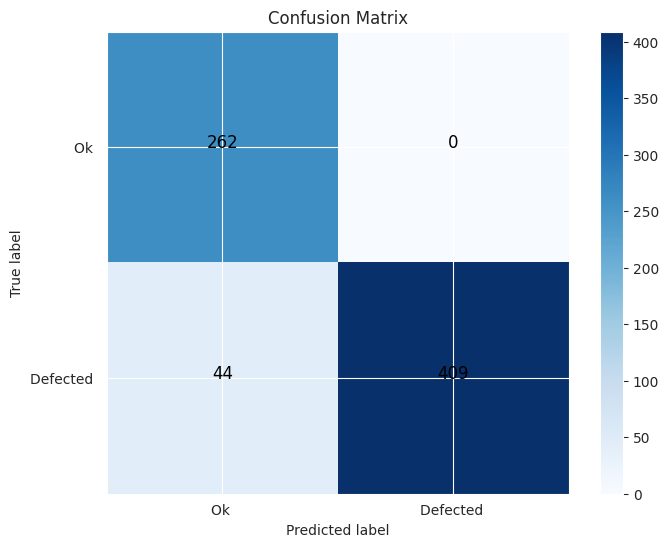

In [13]:

total_samples = np.sum(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title(f'Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Ok ', 'Defected '])
plt.yticks(tick_marks, ['Ok ', 'Defected '])
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j]
        plt.text(j, i, f'{count}', horizontalalignment='center', color='black', fontsize=12)

plt.show()

In [14]:
from google.colab import files

# Download the file
files.download("model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>